In [10]:
import numpy as np
from classy import Class
import functions as f
from scipy.stats import qmc
import scipy.integrate
import warnings
from colossus.cosmology import cosmology
import matplotlib.pyplot as plt

In [11]:
# dimensions
nk = 100
nz = 20
nc = 200




# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Pedro code for power spectrum zero-baryon and transfer function Eisensten - Hu
# I modified slightly the original script: the function 'get_pk' now is 'get_pk_tk' and returns a list with both the power 
#   spectrum and the transfer function

def pk_EisensteinHu_zb(k, sigma8, Om, Ob, h, ns, use_colossus=False):
    """
    Compute the Eisentein & Hu 1998 zero-baryon approximation to P(k) at z=0
    
    Args:
        :k (np.ndarray): k values to evaluate P(k) at [h / Mpc]
        :sigma8 (float): Root-mean-square density fluctuation when the linearly
            evolved field is smoothed with a top-hat filter of radius 8 Mpc/h
        :Om (float): The z=0 total matter density parameter, Omega_m
        :Ob (float): The z=0 baryonic density parameter, Omega_b
        :h (float): Hubble constant, H0, divided by 100 km/s/Mpc
        :ns (float): Spectral tilt of primordial power spectrum
        :use_colossus (bool, default=False): Whether to use the external package colossus
            to compute this term
        
    Returns:
        :pk_eh (np.ndarray): The Eisenstein & Hu 1998 zero-baryon P(k) [(Mpc/h)^3]
    """

    if use_colossus:
        cosmo_params = {
            'flat':True,
            'sigma8':sigma8,
            'Om0':Om,
            'Ob0':Ob,
            'H0':h*100.,
            'ns':ns,
        }
        cosmo = cosmology.setCosmology('myCosmo', **cosmo_params)
        pk_eh = cosmo.matterPowerSpectrum(k, z = 0.0, model='eisenstein98_zb')
    else:
        ombom0 = Ob / Om
        om0h2 = Om * h**2
        ombh2 = Ob * h**2
        theta2p7 = 2.7255 / 2.7 # Assuming Tcmb0 = 2.7255 Kelvin

        def get_pk_tk(kk, Anorm):
        
            # Compute scale factor s, alphaGamma, and effective shape Gamma
            s = 44.5 * np.log(9.83 / om0h2) / np.sqrt(1.0 + 10.0 * ombh2**0.75)
            alphaGamma = 1.0 - 0.328 * np.log(431.0 * om0h2) * ombom0 + \
            0.38 * np.log(22.3 * om0h2) * ombom0**2
            Gamma = Om * h * (alphaGamma + (1.0 - alphaGamma) / \
                (1.0 + (0.43 * kk * h * s)**4))
            
            # Compute q, C0, L0, and tk_eh
            q = kk * theta2p7**2 / Gamma
            C0 = 14.2 + 731.0 / (1.0 + 62.5 * q)
            L0 = np.log(2.0 * np.exp(1.0) + 1.8 * q)
            tk_eh = L0 / (L0 + C0 * q**2)

            # Calculate Pk with unit amplitude
            pk_eh = Anorm * tk_eh**2 * kk**ns
            return [pk_eh, tk_eh]
        
        # Define integration bounds and number of sub-intervals
        b0 = np.log(1e-7) # ln(k_min)
        b1 = np.log(1e5)  # ln(k_max)
        n = 1000      # Number of sub-intervals (make sure it's even for Simpson's Rule)

        # Find normalisation
        R = 8.0
        kk = np.exp(np.linspace(b0, b1, n))
        x = kk * R
        W = np.zeros(x.shape)
        m = x < 1.e-3
        W[m] = 1.0
        W[~m] =3.0 / x[~m]**3 * (np.sin(x[~m]) - x[~m] * np.cos(x[~m]))
        y = get_pk_tk(kk, 1.0)[0] * W**2 * kk**3
        sigma2 = scipy.integrate.simpson(y, x=np.log(x))
        
        sigmaExact = np.sqrt(sigma2 / (2.0 * np.pi**2))
        Anorm = (sigma8 / sigmaExact)**2
        
        pk_tk_eh = get_pk_tk(k, Anorm)
        
    return pk_tk_eh




# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# codice di Pedro per power spectrum baryon

def pk_EisensteinHu_b(k, sigma8, Om, Ob, h, ns):
    """
    Compute the Eisentein & Hu 1998 baryon approximation to P(k) at z=0
    
    Args:
        :k (np.ndarray): k values to evaluate P(k) at [h / Mpc]
        :sigma8 (float): Root-mean-square density fluctuation when the linearly
            evolved field is smoothed with a top-hat filter of radius 8 Mpc/h
        :Om (float): The z=0 total matter density parameter, Omega_m
        :Ob (float): The z=0 baryonic density parameter, Omega_b
        :h (float): Hubble constant, H0, divided by 100 km/s/Mpc
        :ns (float): Spectral tilt of primordial power spectrum
        
    Returns:
        :pk_eh (np.ndarray): The Eisenstein & Hu 1998 baryon P(k) [(Mpc/h)^3]
    """

    cosmo_params = {
        'flat':True,
        'sigma8':sigma8,
        'Om0':Om,
        'Ob0':Ob,
        'H0':h*100.,
        'ns':ns,
    }
    cosmo = cosmology.setCosmology('myCosmo', **cosmo_params)
    pk_eh = cosmo.matterPowerSpectrum(k, z = 0.0, model='eisenstein98')
        
    return pk_eh




# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# codice di Pedro per logF

def logF_fiducial(k, sigma8, Om, Ob, h, ns, extrapolate=False):
    """
    Compute the emulated logarithm of the ratio between the true linear
    power spectrum and the Eisenstein & Hu 1998 fit. Here we use the fiducial exprssion
    given in Bartlett et al. 2023.
    
    Args:
        :k (np.ndarray): k values to evaluate P(k) at [h / Mpc]
        :sigma8 (float): Root-mean-square density fluctuation when the linearly
            evolved field is smoothed with a top-hat filter of radius 8 Mpc/h
        :Om (float): The z=0 total matter density parameter, Omega_m
        :Ob (float): The z=0 baryonic density parameter, Omega_b
        :h (float): Hubble constant, H0, divided by 100 km/s/Mpc
        :ns (float): Spectral tilt of primordial power spectrum
        :extrapolate (bool, default=False): If True, then extrapolates the Bartlett
            et al. 2023 fit outside range tested in paper. Otherwise, uses E&H with
            baryons for this regime
        
    Returns:
        :logF (np.ndarray): The logarithm of the ratio between the linear P(k) and the
            Eisenstein & Hu 1998 zero-baryon fit
    """
    
    b = [0.05448654, 0.00379, 0.0396711937097927, 0.127733431568858, 1.35,
        4.053543862744234, 0.0008084539054750851, 1.8852431049189666,
        0.11418372931475675, 3.798, 14.909, 5.56, 15.8274343004709, 0.0230755621512691,
        0.86531976, 0.8425442636372944, 4.553956000000005, 5.116999999999995,
        70.0234239999998, 0.01107, 5.35, 6.421, 134.309, 5.324, 21.532,
        4.741999999999985, 16.68722499999999, 3.078, 16.987, 0.05881491,
        0.0006864690561825617, 195.498, 0.0038454457516892, 0.276696018851544,
        7.385, 12.3960625361899, 0.0134114370723638]
        
    line1 = b[0] * h - b[1]
    
    line2 = (
        ((Ob * b[2]) / np.sqrt(h ** 2 + b[3])) ** (b[4] * Om) *
        (
            (b[5] * k - Ob) / np.sqrt(b[6] + (Ob - b[7] * k) ** 2)
            * b[8] * (b[9] * k) ** (-b[10] * k) * np.cos(Om * b[11]
            - (b[12] * k) / np.sqrt(b[13] + Ob ** 2))
            - b[14] * ((b[15] * k) / np.sqrt(1 + b[16] * k ** 2) - Om)
            * np.cos(b[17] * h / np.sqrt(1 + b[18] * k ** 2))
        )
    )
    
    line3 = (
        b[19] *  (b[20] * Om + b[21] * h - np.log(b[22] * k)
        + (b[23] * k) ** (- b[24] * k)) * np.cos(b[25] / np.sqrt(1 + b[26] * k ** 2))
    )
    
    line4 = (
        (b[27] * k) ** (-b[28] * k) * (b[29] * k - (b[30] * np.log(b[31] * k))
        / np.sqrt(b[32] + (Om - b[33] * h) ** 2))
        * np.cos(Om * b[34] - (b[35] * k) / np.sqrt(Ob ** 2 + b[36]))
    )
    
    logF = line1 + line2 + line3 + line4
    
    # Use Bartlett et al. 2023 P(k) only in tested regime
    m = ~((k >= 9.e-3) & (k <= 9))
    if (not extrapolate) and m.sum() > 0:
        warnings.warn("Not using Bartlett et al. formula outside tested regime")
        logF[m] = np.log(
            pk_EisensteinHu_b(k[m], sigma8, Om, Ob, h, ns) /
            pk_EisensteinHu_zb(k[m], sigma8, Om, Ob, h, ns)[0]
        )

    return logF




# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# estrazione transfer function con codice Pedro (transfer(Eisensten e Hu)**2) * exp(log(F_fiducial))

def Transfer2(kk) :

    # using CLASS default cosmological parameters
    h = 0.67810
    Ob = 0.02238280
    Oc = 0.1201075/(h**2)
    On = 0.06/((h**2) * 93.14)
    Om = On + Ob + Oc
    sigma8 = 0.824398
    ns = 0.9660499

    # transfer function Eisensten - Hu
    tf_eh2 = pk_EisensteinHu_zb(kk, sigma8, Om, Ob, h, ns)[1] ** 2
    F = np.exp(logF_fiducial(kk, sigma8, Om, Ob, h, ns))

    return tf_eh2*F




# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# funzione che calcola il power spectrum primordiale (valori dei parametri presi da class e da tesi francesco)
# k NON è in unità h/Mpc

def Prim(kk) :
    As = 2.100549e-09
    ns = 0.9660499
    k_piv = 0.05

    return ((2*np.pi*As) / (kk**3)) * ((kk/k_piv)**(ns-1))




# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# funzione che calcola mu secondo il modello 'mu_VBCh'

def Mu_VBCh (k, z, On, Ob, Oc, h) :

    mu = ( (z + 0.913)**((15.9*On)**((k + Oc - 0.254)/(h**2.23))) ) ** (-1.62*On)

    return mu



'''
# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# parametri cosmologici

# ipercubo con nc combinazioni
sampler = qmc.LatinHypercube(d=4)
sample = sampler.random(n=nc)

# ipercubo: [Omega_nu,                  Omega_b,    Omega_c,   h]
inf =       [0.06/(93.14*(0.8**2)),     0.04,       0.23,      0.6]
sup =       [1/(93.14*(0.6**2)),        0.06,       0.29,      0.8]
input = qmc.scale(sample, inf, sup).T
np.save('../files/input_neu_sym_' + str(nc), input)




# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# estraggo da CLASS il power spectrum
# calcolo la quantità da predire con la rete neurale

output = np.zeros([nc,nk,nz])
for c in range(nc) :
    LCDM = Class()

    LCDM.set({
        'Omega_ncdm': input[0,c],
        'Omega_b': input[1,c],
        'Omega_cdm': input[2,c],
        'h': input[3,c],
        'tau_reio': 0.05430842,
        'z_max_pk': 10,
        'N_ncdm': 1
        })
    LCDM.set({
        'output': 'tCl,pCl,lCl,mPk',
        'lensing':'yes',
        'P_k_max_h/Mpc': 10, 
        'z_max_pk': 10
        })
    LCDM.compute()

    h = LCDM.h()
    zz = np.linspace(0, 5, nz)
    kk = np.logspace(-4, np.log10(3), nk)*h

    pkz = np.zeros([nk,nz])
    mu2 = np.zeros([nk,nz])
    prim = Prim(kk)
    tf2 = Transfer2(kk)

    for k in range(nk) :
        for z in range(nz) :
            pkz[k,z] = LCDM.pk_lin(kk[k], zz[z])*(h**3)
            mu2[k,z] = (Mu_VBCh(kk[k], zz[z], input[0,c], input[1,c], input[2,c], input[3,c])) **2

            output[c,k,z] = pkz[k,z] / (prim[k] * tf2[k] * mu2[k,z])

    print(c+1, '/', nc)

output = np.reshape(output, [nc,nk*nz])
np.save('../files/output_neu_sym_' + str(nc), output)
'''


# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# parametri cosmologici

nn = 20
nb = 20
nh = 10
onon = np.linspace(0.06/(93.14*(0.8**2)), 1/(93.14*(0.6**2)), nn)
obob = np.linspace(0.04, 0.06, nb)
hh = np.linspace(0.6, 0.8, nh)



# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# estraggo da CLASS il power spectrum
# calcolo la quantità da predire con la rete neurale
'''
input = np.zeros([nb*nh, 2])
output = np.zeros([nb*nh,nk,nz])
for b in range(nb) :
    for h in range(nh) :
        LCDM = Class()

        LCDM.set({
            'Omega_ncdm': 0.06/((0.67810**2) * 93.14),
            'Omega_b': obob[b],
            'Omega_cdm': 0.1201075/(0.67810**2),
            'h': hh[h],
            'tau_reio': 0.05430842,
            'z_max_pk': 10,
            'N_ncdm': 1
            })
        LCDM.set({
            'output': 'tCl,pCl,lCl,mPk',
            'lensing':'yes',
            'P_k_max_h/Mpc': 10, 
            'z_max_pk': 10
            })
        LCDM.compute()

        input[b*nh + h,0] = obob[b]
        input[b*nh + h,1] = hh[h]

        zz = np.linspace(0, 5, nz)
        kk = np.logspace(-4, np.log10(3), nk)*hh[h]

        pkz = np.zeros([nk,nz])
        mu2 = np.zeros([nk,nz])
        prim = Prim(kk)
        tf2 = Transfer2(kk)

        for k in range(nk) :
            for z in range(nz) :
                pkz[k,z] = LCDM.pk_lin(kk[k], zz[z])*(hh[h]**3)
                mu2[k,z] = (Mu_VBCh(kk[k], zz[z], 0.06/((0.67810**2) * 93.14), obob[b], 0.1201075/(0.67810**2), hh[h])) **2

                output[b*nh + h,k,z] = pkz[k,z] / (prim[k] * tf2[k] * mu2[k,z])

        print(b*nh + h + 1, '/', nb*nh)

output = np.reshape(output, [nb*nh,nk*nz])

np.save('../files/input_neu_sym_Bh_' + str(nb*nh), input)
print('input Bh salvato')
np.save('../files/output_neu_sym_Bh_' + str(nb*nh), output)
print('output Bh salvato\n')


input = np.zeros([nn*nh, 2])
output = np.zeros([nn*nh,nk,nz])
for n in range(nn) :
    for h in range(nh) :
        LCDM = Class()

        LCDM.set({
            'Omega_ncdm': onon[n],
            'Omega_b': 0.02238280/(0.67810**2),
            'Omega_cdm': 0.1201075/(0.67810**2),
            'h': hh[h],
            'tau_reio': 0.05430842,
            'z_max_pk': 10,
            'N_ncdm': 1
            })
        LCDM.set({
            'output': 'tCl,pCl,lCl,mPk',
            'lensing':'yes',
            'P_k_max_h/Mpc': 10, 
            'z_max_pk': 10
            })
        LCDM.compute()

        input[n*nh + h,0] = onon[n]
        input[n*nh + h,1] = hh[h]

        zz = np.linspace(0, 5, nz)
        kk = np.logspace(-4, np.log10(3), nk)*hh[h]

        pkz = np.zeros([nk,nz])
        mu2 = np.zeros([nk,nz])
        prim = Prim(kk)
        tf2 = Transfer2(kk)

        for k in range(nk) :
            for z in range(nz) :
                pkz[k,z] = LCDM.pk_lin(kk[k], zz[z])*(hh[h]**3)
                mu2[k,z] = (Mu_VBCh(kk[k], zz[z], onon[n], 0.02238280/(0.67810**2), 0.1201075/(0.67810**2), hh[h])) **2

                output[n*nh + h,k,z] = pkz[k,z] / (prim[k] * tf2[k] * mu2[k,z])

        print(n*nh + h + 1, '/', nn*nh)

output = np.reshape(output, [nn*nh,nk*nz])

np.save('../files/input_neu_sym_Vh_' + str(nn*nh), input)
print('input Vh salvato\n')
np.save('../files/output_neu_sym_Vh_' + str(nn*nh), output)
print('output Vh salvato\n')
'''


"\ninput = np.zeros([nb*nh, 2])\noutput = np.zeros([nb*nh,nk,nz])\nfor b in range(nb) :\n    for h in range(nh) :\n        LCDM = Class()\n\n        LCDM.set({\n            'Omega_ncdm': 0.06/((0.67810**2) * 93.14),\n            'Omega_b': obob[b],\n            'Omega_cdm': 0.1201075/(0.67810**2),\n            'h': hh[h],\n            'tau_reio': 0.05430842,\n            'z_max_pk': 10,\n            'N_ncdm': 1\n            })\n        LCDM.set({\n            'output': 'tCl,pCl,lCl,mPk',\n            'lensing':'yes',\n            'P_k_max_h/Mpc': 10, \n            'z_max_pk': 10\n            })\n        LCDM.compute()\n\n        input[b*nh + h,0] = obob[b]\n        input[b*nh + h,1] = hh[h]\n\n        zz = np.linspace(0, 5, nz)\n        kk = np.logspace(-4, np.log10(3), nk)*hh[h]\n\n        pkz = np.zeros([nk,nz])\n        mu2 = np.zeros([nk,nz])\n        prim = Prim(kk)\n        tf2 = Transfer2(kk)\n\n        for k in range(nk) :\n            for z in range(nz) :\n                pkz[

In [12]:
LCDM = Class()

LCDM.set({
    'Omega_ncdm': 0.06/((0.67810**2) * 93.14),
    'Omega_b': 0.02,
    'Omega_cdm': 0.1201075/(0.67810**2),
    'h': 0.67,
    'tau_reio': 0.05430842,
    'z_max_pk': 10,
    'N_ncdm': 1
    })
LCDM.set({
    'output': 'tCl,pCl,lCl,mPk',
    'lensing':'yes',
    'P_k_max_h/Mpc': 10, 
    'z_max_pk': 10
    })
LCDM.compute()
h = LCDM.h()

zz = np.linspace(0, 5, nz)
kk = np.logspace(-4, np.log10(3), nk)
kkh = kk*h

output = np.zeros([nk,nz])
pkz = np.zeros([nk,nz])
mu2 = np.zeros([nk,nz])

prim = Prim(kk)
tf2 = Transfer2(kkh)

for k in range(nk) :
    for z in range(nz) :
        pkz[k,z] = LCDM.pk_lin(kkh[k], zz[z])*(h**3)
        mu2[k,z] = (Mu_VBCh(kkh[k], zz[z], 0.06/((0.67810**2) * 93.14), 0.02, 0.1201075/(0.67810**2), h)) **2

        output[k,z] = pkz[k,z] / (prim[k] * tf2[k] * mu2[k,z])



/var/folders/ll/brfzdrlx3nndb4spv5812khr0000gn/T/ipykernel_87877/3863073860.py:195: UserWarning: Not using Bartlett et al. formula outside tested regime
  warnings.warn("Not using Bartlett et al. formula outside tested regime")


Training dataset:
[[3.01295243e-02 2.31363614e-02 1.78147112e-02 ... 1.69795985e-03
  1.54668907e-03 1.41465752e-03]
 [4.56950789e-02 3.50891617e-02 2.70182681e-02 ... 2.57521444e-03
  2.34579083e-03 2.14554613e-03]
 [6.93012010e-02 5.32163734e-02 4.09761125e-02 ... 3.90567026e-03
  3.55772041e-03 3.25402381e-03]
 ...
 [2.05972848e+15 1.58169330e+15 1.21821533e+15 ... 1.17026702e+14
  1.06656349e+14 9.76023029e+13]
 [3.10043426e+15 2.38086573e+15 1.83373570e+15 ... 1.76156211e+14
  1.60546149e+14 1.46917405e+14]
 [4.66822327e+15 3.58479279e+15 2.76099706e+15 ... 2.65233119e+14
  2.41729512e+14 2.21209134e+14]]


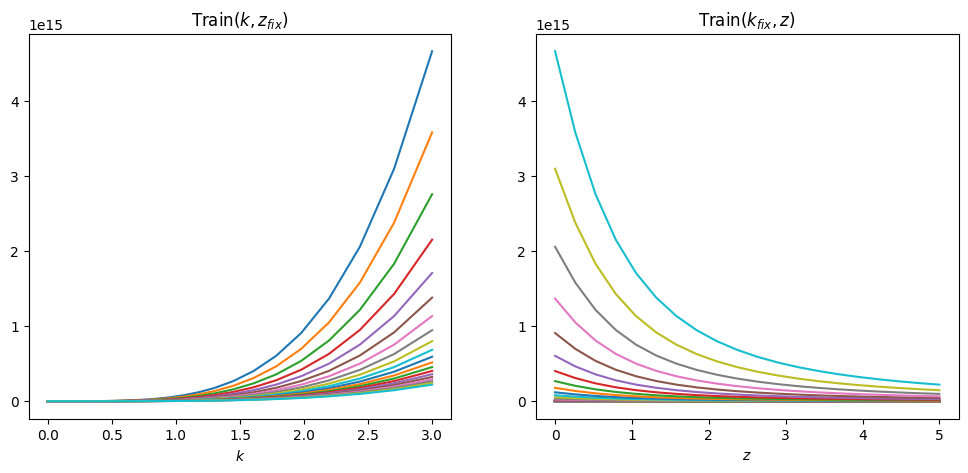

In [13]:
print('Training dataset:')
print(output)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})

for i in range(nz) :
    axs[0].plot(kk, output[:,i])

for i in range(nk) :
    axs[1].plot(zz, output[i,:])

axs[0].set_title(r'Train$(k,z_{fix})$')
axs[0].set_xlabel(r'$k$')
axs[1].set_title(r'Train$(k_{fix},z)$')
axs[1].set_xlabel(r'$z$')

plt.savefig('../plots/train_check.pdf')
plt.show()

Power spectrum CLASS:
[[4.94778832e+02 3.79530988e+02 2.91983924e+02 ... 2.76742533e+01
  2.52036609e+01 2.30477240e+01]
 [5.47100487e+02 4.19666246e+02 3.22861717e+02 ... 3.06013757e+01
  2.78694861e+01 2.54855293e+01]
 [6.04944757e+02 4.64038104e+02 3.56999122e+02 ... 3.38376864e+01
  3.08169058e+01 2.81808491e+01]
 ...
 [8.24819735e+00 6.33390207e+00 4.87835192e+00 ... 4.68634257e-01
  4.27106105e-01 3.90849115e-01]
 [6.37694376e+00 4.89694203e+00 3.77161018e+00 ... 3.62316422e-01
  3.30209796e-01 3.02178324e-01]
 [4.92291258e+00 3.78037221e+00 2.91163176e+00 ... 2.79703729e-01
  2.54917810e-01 2.33277880e-01]]


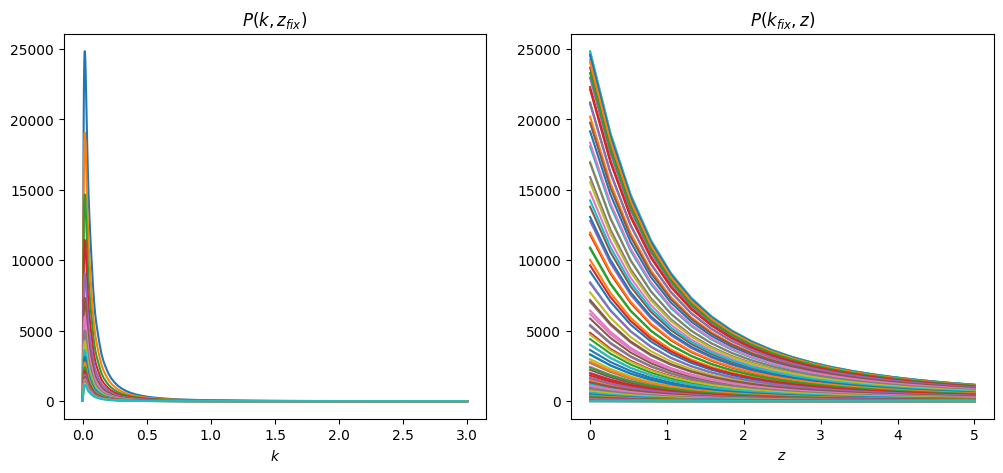

In [14]:
print('Power spectrum CLASS:')
print(pkz)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})

for i in range(nz) :
    axs[0].plot(kk, pkz[:,i])

for i in range(nk) :
    axs[1].plot(zz, pkz[i,:])

axs[0].set_title(r'$P(k,z_{fix})$')
axs[0].set_xlabel(r'$k$')
axs[1].set_title(r'$P(k_{fix},z)$')
axs[1].set_xlabel(r'$z$')

plt.savefig('../plots/pkz_check.pdf')
plt.show()

Mu^2 allenato con PySR:
[[1.00038623 0.99931188 0.99845621 ... 0.99288137 0.99268047 0.99248876]
 [1.0003862  0.99931192 0.99845631 ... 0.99288185 0.99268097 0.99248927]
 [1.00038617 0.99931198 0.99845643 ... 0.99288239 0.99268152 0.99248984]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


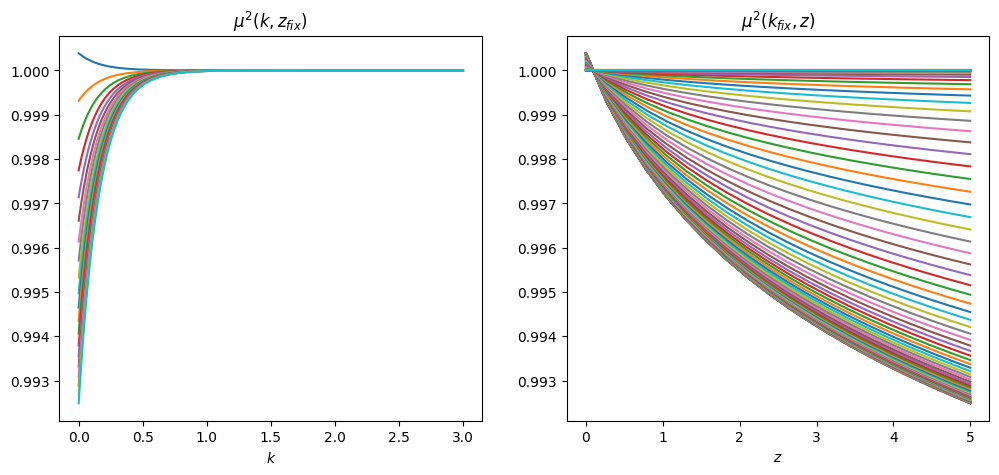

In [15]:
print('Mu^2 allenato con PySR:')
print(mu2)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})

for i in range(nz) :
    axs[0].plot(kk, mu2[:,i])

for i in range(nk) :
    axs[1].plot(zz, mu2[i,:])

axs[0].set_title(r'$\mu^2(k,z_{fix})$')
axs[0].set_xlabel(r'$k$')
axs[1].set_title(r'$\mu^2(k_{fix},z)$')
axs[1].set_xlabel(r'$z$')

plt.savefig('../plots/mu_check.pdf')
plt.show()

Power spectrum primordiale:
[1.62983255e+04 1.18833067e+04 8.66426294e+03 6.31721913e+03
 4.60596104e+03 3.35826203e+03 2.44854955e+03 1.78526716e+03
 1.30165992e+03 9.49056029e+02 6.91968255e+02 5.04522442e+02
 3.67853428e+02 2.68206393e+02 1.95552532e+02 1.42579722e+02
 1.03956603e+02 7.57960196e+01 5.52637967e+01 4.02935040e+01
 2.93784822e+01 2.14202075e+01 1.56177329e+01 1.13870784e+01
 8.30245687e+00 6.05342194e+00 4.41362332e+00 3.21802626e+00
 2.34630195e+00 1.71071719e+00 1.24730464e+00 9.09424934e-01
 6.63072743e-01 4.83454374e-01 3.52492444e-01 2.57006514e-01
 1.87386565e-01 1.36625816e-01 9.96155383e-02 7.26308964e-02
 5.29560670e-02 3.86109103e-02 2.81516827e-02 2.05257331e-02
 1.49655608e-02 1.09115718e-02 7.95575926e-03 5.80064051e-03
 4.22931731e-03 3.08364652e-03 2.24832405e-03 1.63928032e-03
 1.19521915e-03 8.71448771e-04 6.35383862e-04 4.63266076e-04
 3.37772911e-04 2.46274324e-04 1.79561595e-04 1.30920535e-04
 9.54557492e-05 6.95979438e-05 5.07447045e-05 3.69985791e

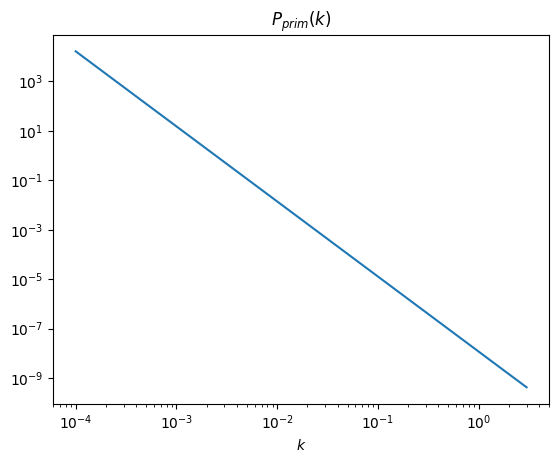

In [16]:
print('Power spectrum primordiale:')
print(prim)

plt.loglog(kk, prim)

plt.title(r'$P_{prim}(k)$')
plt.xlabel(r'$k$')

plt.savefig('../plots/prim_check.pdf')
plt.show()

Transfer function di Pedro al quadrato:
[1.00718244e+00 1.00714656e+00 1.00710709e+00 1.00706391e+00
 1.00701687e+00 1.00696445e+00 1.00690159e+00 1.00682350e+00
 1.00672736e+00 1.00660994e+00 1.00646623e+00 1.00629045e+00
 1.00607547e+00 1.00581306e+00 1.00549280e+00 1.00510264e+00
 1.00462754e+00 1.00405020e+00 1.00334920e+00 1.00249994e+00
 1.00147235e+00 1.00023214e+00 9.98737824e-01 9.96942554e-01
 9.94790459e-01 9.92219148e-01 9.89155497e-01 9.85519035e-01
 9.81217387e-01 9.76150792e-01 9.70207583e-01 9.63270033e-01
 9.55210404e-01 9.45898173e-01 9.35197210e-01 9.22974179e-01
 9.09097235e-01 8.93445038e-01 8.75906986e-01 8.56391929e-01
 8.34829442e-01 8.11177137e-01 7.85422036e-01 7.57585441e-01
 7.27723332e-01 6.95928093e-01 6.62327165e-01 6.27081675e-01
 6.06341998e-01 5.68436030e-01 5.29279041e-01 4.89036113e-01
 4.47905422e-01 4.06179168e-01 3.64317589e-01 3.22985977e-01
 2.83002738e-01 2.45204774e-01 2.10306128e-01 1.78820609e-01
 1.51047897e-01 1.27076574e-01 1.06772329e-01

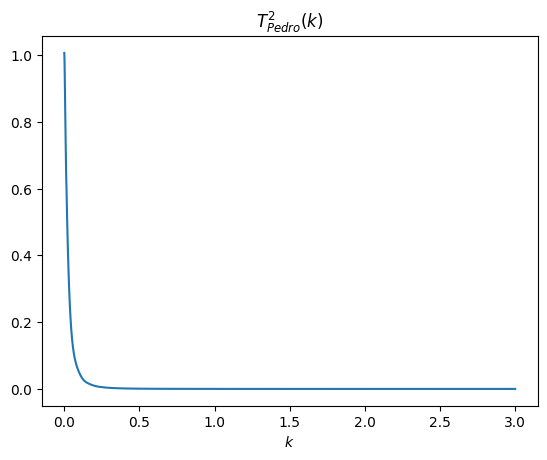

In [17]:
print('Transfer function di Pedro al quadrato:')
print(tf2)

plt.plot(kk, tf2)

plt.title(r'$T_{Pedro}^2(k)$')
plt.xlabel(r'$k$')

plt.savefig('../plots/tf_check.pdf')
plt.show()